In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

import numpy as np
import scipy
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVR, SVC
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, TweedieRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
# import eli5
# from eli5.sklearn import PermutationImportance
# import shap
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
def fit_and_tune_model(X, y, CV_SPLITS=5, scoring=None, CV_SPLITS_GS=2):
  """A generic integrated pipeline that handles preprocessing, modeling, tuning, and resampling.

  Args:
      X (DataFrame): predictors.
      y (DataFrame): outcomes.
      CV_SPLITS (int, optional): Number of cross-validation folds. It will be use for both test/train
        splitting and analysis/assessment folds. Defaults to 5.

  Returns:
      (model, X_train, X_test, y_train, y_test): A tuple of the best tuned model and test/train splits.
  """

  # split the data into train and test. Test set won't be used.
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/CV_SPLITS)

  # X_train, X_test, y_train, y_test  = X,X,y,y
 
  # categorize features into labels, categorical features, and numerical features.
  lbl_features = [c for c in X.columns if c.endswith('_index')]
  cat_features = X.select_dtypes(['category']).columns.to_list()
  num_features = X.select_dtypes(['float64', 'int64']).columns.to_list()
  num_features = list(set(num_features) - set(lbl_features))


  # pipeline to preprocess label features
  lbl_pipe = Pipeline([
      ('lbl', OrdinalEncoder())
  ])

  # pipeline to preprocess categorical features
  cat_pipe = Pipeline([
      ('ohe', OneHotEncoder(handle_unknown='ignore'))
  ])

  # pipeline to preprocess numerical features
  num_pipe = Pipeline([
      ('imputer', SimpleImputer(strategy='mean'))
  ])

  # preprocessing pipeline (combines pipelines for labels, categories, and numerical features)
  prep_pipe = ColumnTransformer([
      # ('lbl', lbl_pipe, lbl_features),
      ('cat', cat_pipe, cat_features),
      ('num', num_pipe, num_features)
  ])

  # main modeling pipeline (values are temporary; will be redefined by the tuning part)
  pipeline = Pipeline([
      # ('preprocess', prep_pipe),
    #   ('scaler', StandardScaler()),
      # ('reduce_dim', PCA(20)),
      ('estimator', SVR(kernel="linear")),
      # PLSRegression()),
  ])

  # define a space of all possible model parameters to search for using grid and randomized tuning.
  # Some of the models take time to be fitted; comment them if you're debugging.
  params_space = [{
#       # standard models (scale -> reduce dimensionality -> estimate multiple outcomes)
#       # 'scaler': [None],  # , RobustScaler(), QuantileTransformer()],
#     #   'reduce_dim': [None], #[PCA(n_components=n) for n in np.arange(1, len(X.columns) - 1)],
#       'estimator': [TweedieRegressor(power=0, link='auto', fit_intercept=p) for p in [True, False]]
#   },
#   {
#       # PLS model (scale -> estimate outcomes)
#       # 'scalxer': [None, StandardScaler(), RobustScaler()],
#     #   'reduce_dim': [None],
#       'estimator': [PLSRegression(n_components=p) for p in np.arange(1, len(X.columns))]
#   },
#   {
#       # Multilayer neural network model (scale -> estimate using randomized hidden layers)
#       # 'scaler': [StandardScaler()],
#     #   'reduce_dim': [None],
#       'estimator': [MLPClassifier()],
#       # 'estimator__hidden_layer_sizes': [RandomHiddenLayerSizes()],
#       # scipy random distribution
#       # 'estimator__hidden_layer_sizes': scipy.stats.poisson(10, 100),
#       # numpy randomizer (grid search)
#       'estimator__hidden_layer_sizes': [np.random.randint(10, 100, size=n_layers) for n_layers in [1, 2, 3]]
#   },
#   {
#     # Multilayer neural network model (scale -> estimate using randomized hidden layers)
#     # 'scaler': [StandardScaler()],
#     # 'reduce_dim': [None],
#     'estimator': [RandomForestClassifier()],
  
# },
# {
    # Multilayer neural network model (scale -> estimate using randomized hidden layers)
    # 'scaler': [StandardScaler()],
    # 'reduce_dim': [None],
    'estimator': [SVR(kernel="rbf")]
  
    }]

  # define the parameter tuning search and fit it (uses -MSE to score and compare models)
  # grid_search = GridSearchCV(pipeline,
  #                                  params_space,
  #                                  cv=CV_SPLITS_GS,
  #                                  scoring= scoring,
  #                                  verbose=0,
  #                                  n_jobs=-1)
  # grid_search.fit(X_train, y_train)

  pipeline.fit(X_train,y_train)

  # # find the best fitted model (the one with highest -MSE score)
  # best_model = grid_search.best_estimator_
#   print('Best params: ', grid_search.best_params_,)
#   print(grid_search.scoring)

  # calculate model scores on train and test sets (This is a model-specific score, not the -MSE anymore).
  # It uses CV to reliably calculate the prediction score on the train set.

  # cv_scores = cross_val_score(best_model, X_train, y_train, cv=CV_SPLITS)
  # train_score = cv_scores.mean()
  # print(f'train set score ({CV_SPLITS}-fold CV): {train_score:.2f}')
  train_score = pipeline.score(X_train, y_train)
#   print(f'train score {scoring}: {train_score:.2f}')

  test_score = pipeline.score(X_test, y_test)
#   print(f'test score {scoring}: {test_score:.2f}')

  return pipeline, X_train, X_test, y_train, y_test


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_50840/2720631006.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  [data1.rename(columns={i:i[:-5]}, inplace=True) for i in data.columns if i != 'hypnosis_depth']
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_50840/2720631006.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  [data1.rename(columns={i:i[:-5]}, inplace=True) for i in data.columns if i != 'hypnosis_depth']
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_50840/2720631006.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

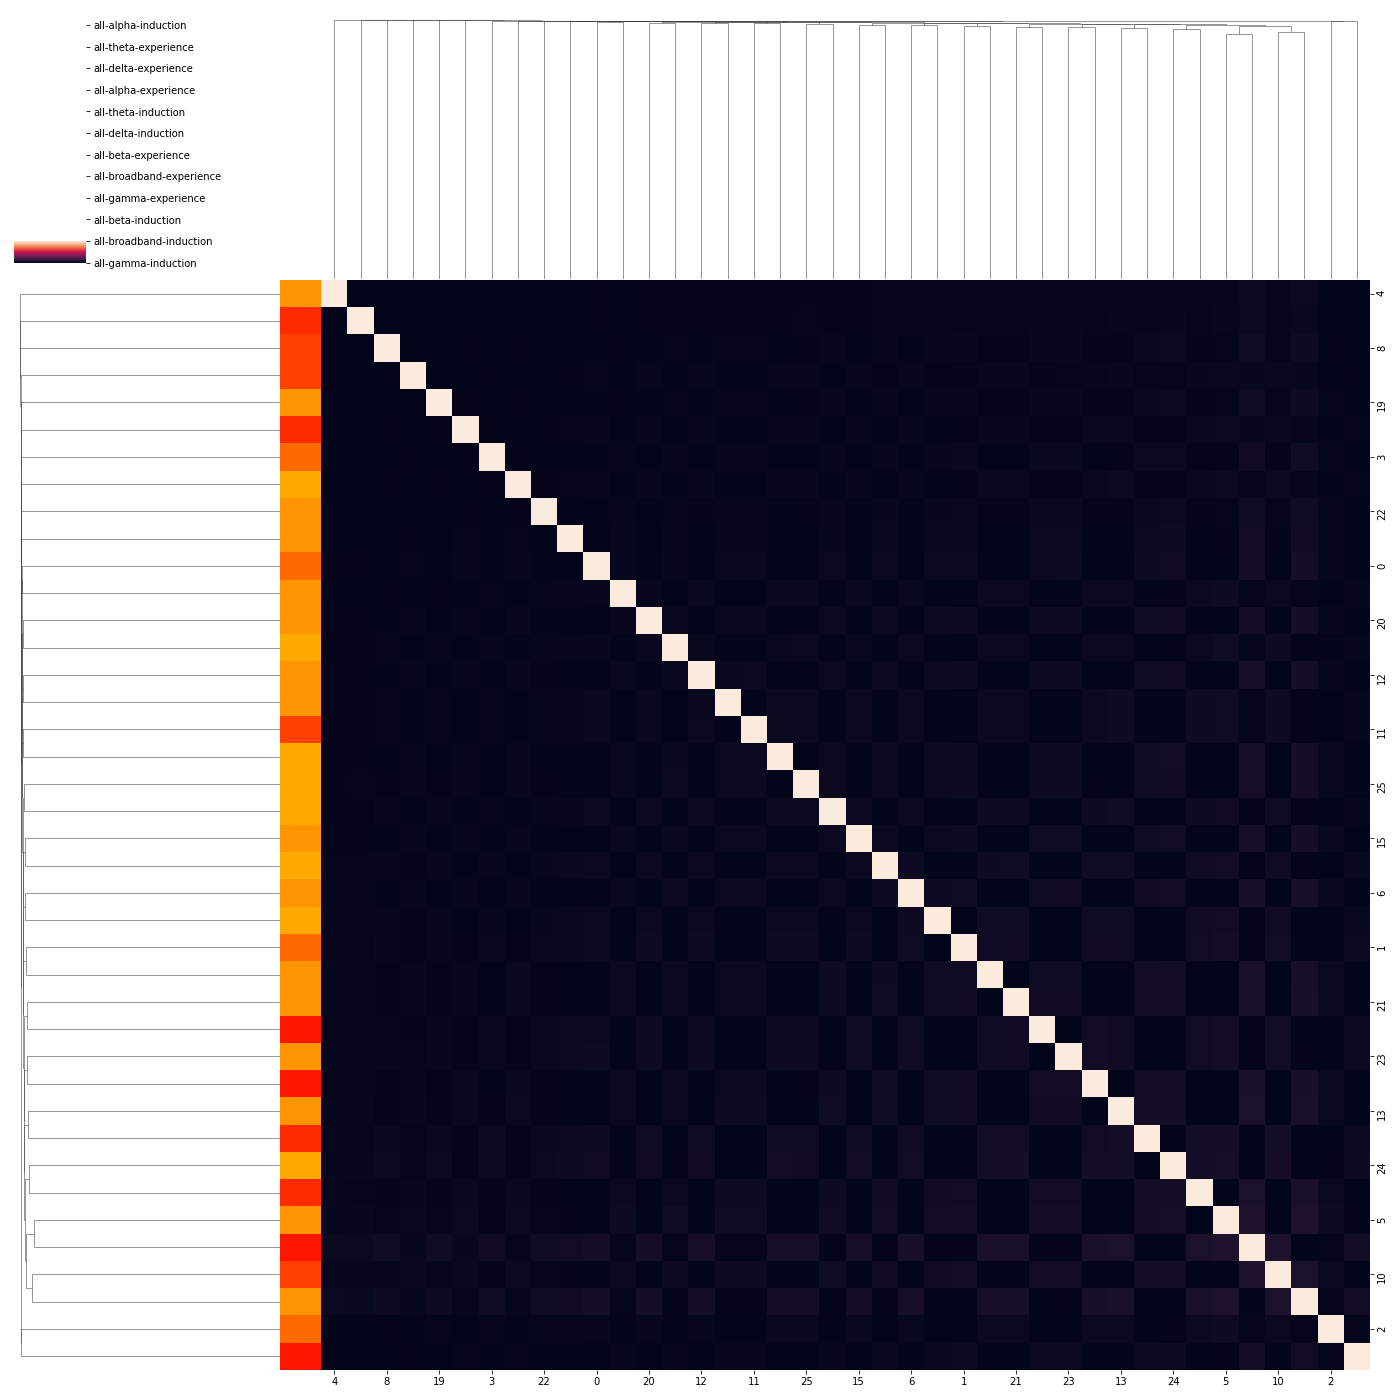

In [9]:
# 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

fname = 'data/behavioral_data/archived/data_with_psds.xlsx'
data = pd.read_excel(fname,index_col= 'Unnamed: 0',header=1)
data.trial_type = data.trial_type.astype('str')
data.dropna(inplace=True)
from scipy.spatial.distance import cosine
import matplotlib.cm as cm
from matplotlib.colors import Normalize

hypno = list(data.drop_duplicates()['hypnotizability_total'])
cmap = cm.autumn
norm = Normalize(vmin=0, vmax=12)
[cmap(norm(c)) for c in hypno]

def umap_similarity(a,b):
    return cosine(a,b)

cor = z.T.corr(method=umap_similarity)
sns.clustermap(cor, robust=True, row_colors=[cmap(norm(c)) for c in hypno])

# correlation
feature_names = [i for i in data.columns if data[i].dtype in [np.float64]]
feature_names = [i for i in feature_names if ('all' in i)]
feature_names = [i for i in feature_names if 'diff' in i]

# feature_names = [i for i in feature_names if 'experience' in i]
feature_names.append('hypnosis_depth')

data1 = data[feature_names]
[data1.rename(columns={i:i[:-5]}, inplace=True) for i in data.columns if i != 'hypnosis_depth']
bar = data1.corr()['hypnosis_depth'].sort_values().drop('hypnosis_depth').plot(kind='barh', figsize=(20,20), colormap='ocean')
# plt.setp(title_obj, color='g') 
label_obj = plt.xlabel('Pearson Correlation', fontdict = {'fontsize' : 17})
plt.setp(label_obj, color='g') 
plt.show()
# data[feature_names].corr()['hypnosis_depth'].sort_values().drop('hypnosis_depth').plot(kind='barh', figsize=(20,20))

1. Linear Model based on domain knowledge

In [3]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

fname = 'data/behavioral_data/archived/data_with_psds.xlsx'
data = pd.read_excel(fname,index_col= 'Unnamed: 0',header=1)
data.trial_type = data.trial_type.astype('str')
data.dropna(inplace=True)

In [4]:
col_names = [i for i in data.columns if data[i].dtype in [np.float64]]
col_names.remove('hypnotizability_total')
col_names = [i for i in col_names if 'experience' in i]
col_names = [i for i in col_names if 'diff' not in i]
data_real = data.query('(trial_type == "True") & (description_type == "hypnosis")')

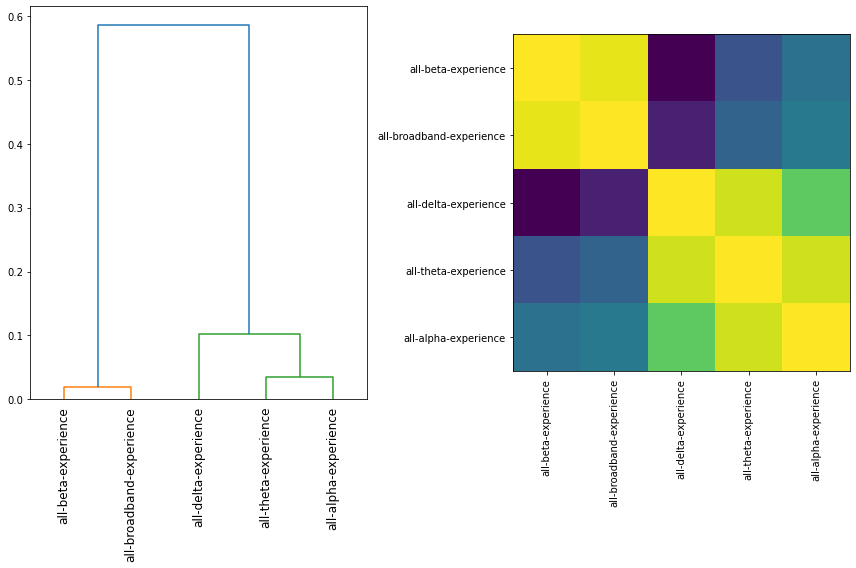

In [5]:
feature_names = [i for i in col_names if ('all' in i) and ('gamma' not in i)]
X = data_real[feature_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T)/2
np.fill_diagonal(corr, 1)

# convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [6]:
# create new features
col_gamma_F = [i for i in col_names if (('gamma' in i) or ('beta' in i)) and ('F' in i)]
fw_F = data_real[col_gamma_F].apply(lambda x:x.mean(), axis=1)

col_gamma_O = [i for i in col_names if (('gamma' in i) or ('beta')) and ('O' in i)]
fw_O = data_real[col_gamma_O].apply(lambda x:x.mean(), axis=1)

col_theta_F = [i for i in col_names if (('theta' in i) or ('alpha' in i) or ('delta' in i)) and ('F' in i)]
sw_F = data_real[col_theta_F].apply(lambda x:x.mean(), axis=1)

col_theta_O = [i for i in col_names if (('theta' in i) or ('alpha' in i) or ('delta' in i)) and ('O' in i)]
sw_O = data_real[col_theta_O].apply(lambda x:x.mean(), axis=1)

X = pd.concat([fw_F,fw_O,sw_F,sw_O],axis=1, keys=['fw_F','fw_O','sw_F','sw_O'])
y = data_real['hypnosis_depth']

In [15]:
def fit_LM_model(X, y, CV_SPLITS=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/CV_SPLITS)

    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # # The coefficients
    # print("Coefficients: \n", regr.coef_)
    # # The mean squared error
    # print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # # The coefficient of determination: 1 is perfect prediction
    # print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

    # Plot outputs
    # plt.scatter(X_test, y_test, color="black")
    # plt.plot(X_test, y_pred, color="blue", linewidth=3)

    # plt.xticks(())
    # plt.yticks(())

    # plt.show()

    return X_train, X_test, y_train, y_test, mse, r_squared



100%|██████████| 100/100 [00:00<00:00, 767.32it/s]

8.055757564886333
-0.31693934817534974



/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

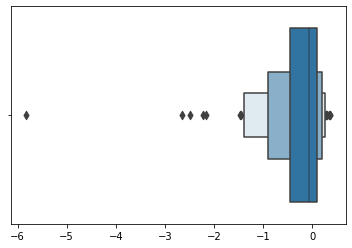

In [16]:
test_scores = []
mses = []


for n_com in tqdm(range(100)):
    
    X_train, X_test, y_train, y_test, mse, r_squared = fit_LM_model(X,y)

    test_scores.append(r_squared)
    mses.append(mse)

print(np.mean(mses))
print(np.mean(test_scores))
sns.boxenplot(test_scores)

2. ML model

In [17]:
def fit_and_tune_model(X, y, CV_SPLITS=5, scoring='r2', CV_SPLITS_GS=2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/CV_SPLITS)
    pipeline = Pipeline([
        ('estimator', SVR()),
    ])
    pipeline.fit(X_train,y_train)

    # cv_scores = cross_val_score(pipeline, X_train, y_train, cv=CV_SPLITS)
    # train_score = cv_scores.mean()
    # print(f'train set score ({CV_SPLITS}-fold CV): {train_score:.2f}')

    test_score = pipeline.score(X_test, y_test)
    # print(f'test score {scoring}: {test_score:.2f}')

    return pipeline, X_train, X_test, y_train, y_test

100%|██████████| 100/100 [00:00<00:00, 356.64it/s]
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


-0.34565929926521627


<AxesSubplot:>

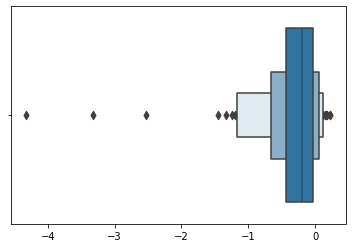

In [202]:
test_scores = []

for n_com in tqdm(range(100)):
    
    model, X_train, X_test, y_train, y_test = fit_and_tune_model(X,y)

    # print the rmse and accuracy
    y_pred = model.predict(X_test)
    # r_squerd = r2_score(y_test, y_pred)
    # print(r_squerd)
    test_scores.append(model.score(X_test,y_test))

print(np.mean(test_scores))
sns.boxenplot(test_scores)

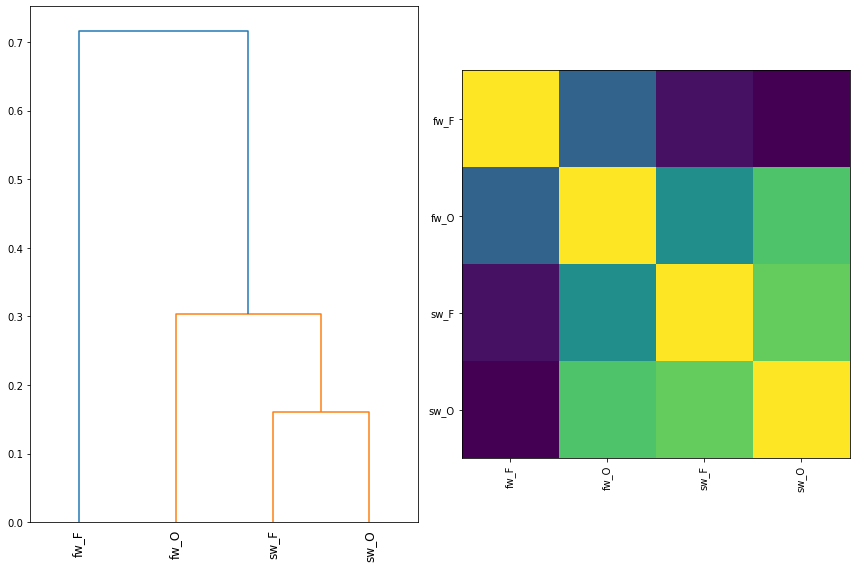

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T)/2
np.fill_diagonal(corr, 1)

# convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

# cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion='distance')
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# s = [col_names[i] for i in selected_features]

# X = X[s]

In [7]:
import umap
# from umap import umap
from sklearn.manifold import TSNE
for n_com in range(1,len(X.columns)):
    z = umap.UMAP(n_components=n_com).fit_transform(X,y)
    # z = TSNE(n_components=3).fit_transform(X)
    z = pd.DataFrame(z)
    # sns.scatterplot(data= df, x=0, y=1)
    z.columns = [str(c) for c in z.columns]

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5)
model = UMAP(n_components=10)
model.fit(X_train,y_train)
z_pred = model.transform(X_test)
model2 = SVR().fit(z_pred)

score = r2_score(y_pred,y_test)

# ELBO

100%|██████████| 1000/1000 [00:12<00:00, 81.81it/s]

-0.35855931460078166



Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

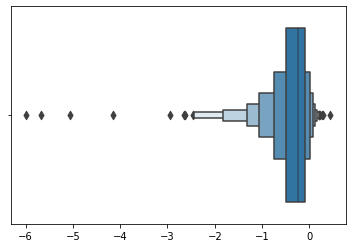

In [294]:

# model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
# model.fit(X, y)
# fit the model
test_scores = []

z = UMAP(n_components=10).fit_transform(X)
# z = PCA(n_components=n_com).fit_transform(X)
z = pd.DataFrame(z)
# sns.scatterplot(data= df, x=0, y=1)
z.columns = [str(c) for c in z.columns]

for n_com in tqdm(range(1000)):
    
    model, X_train, X_test, y_train, y_test = fit_and_tune_model(z, y, CV_SPLITS=5, scoring='r2', CV_SPLITS_GS=2)

    # # # # Permutation Importance. Here, we use test set to calculate mean feature importance.
    # perm_importances = permutation_importance(model, X_test, y_test, n_jobs=-1)
    # sorted_idx = perm_importances.importances_mean.argsort()
    # sorted_importances = perm_importances.importances[sorted_idx]

    # # # # plot feature importances in a box plot
    # fig, ax = plt.subplots(figsize=(10, 20))
    # ax.boxplot(sorted_importances.T,
    #             labels=[i[:-22] for i in X_test.columns[sorted_idx]],
    #             vert=False,)
    # fig.tight_layout()
    # # plt.savefig('permutation_importance.png')
    # plt.show()


    # print the rmse and accuracy
    y_pred = model.predict(X_test)
    # r_squerd = r2_score(y_test, y_pred)
    # print(r_squerd)
    test_scores.append(model.score(X_test,y_test))

print(np.mean(test_scores))
sns.boxenplot(test_scores)

